# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 3

In [104]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [105]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [109]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [110]:
images.as_numpy_iterator().next()

b'data\\images\\98a47aec-d361-11ed-9a01-ffc1cbde35b3.jpg'

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [112]:
images = images.map(load_image)

In [113]:
images.as_numpy_iterator().next()

array([[[210, 193, 199],
        [210, 193, 199],
        [210, 193, 199],
        ...,
        [130, 136, 132],
        [132, 138, 136],
        [133, 139, 137]],

       [[211, 194, 200],
        [211, 194, 200],
        [211, 194, 200],
        ...,
        [130, 136, 134],
        [129, 135, 133],
        [129, 138, 135]],

       [[209, 194, 199],
        [209, 194, 199],
        [210, 193, 199],
        ...,
        [127, 136, 135],
        [128, 137, 136],
        [123, 133, 132]],

       ...,

       [[128, 117, 115],
        [132, 121, 119],
        [135, 123, 123],
        ...,
        [ 78,  76,  77],
        [ 98,  98, 100],
        [102, 102, 104]],

       [[105,  89,  99],
        [117, 104, 114],
        [123, 109, 122],
        ...,
        [ 75,  73,  74],
        [ 94,  94,  96],
        [ 96,  97, 101]],

       [[ 71,  54,  70],
        [ 88,  71,  87],
        [ 88,  73,  92],
        ...,
        [ 79,  79,  79],
        [ 94,  93,  98],
        [ 95,  96, 100]]

In [114]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [115]:
image_generator = images.batch(4).as_numpy_iterator()

In [116]:
plot_images = image_generator.next()

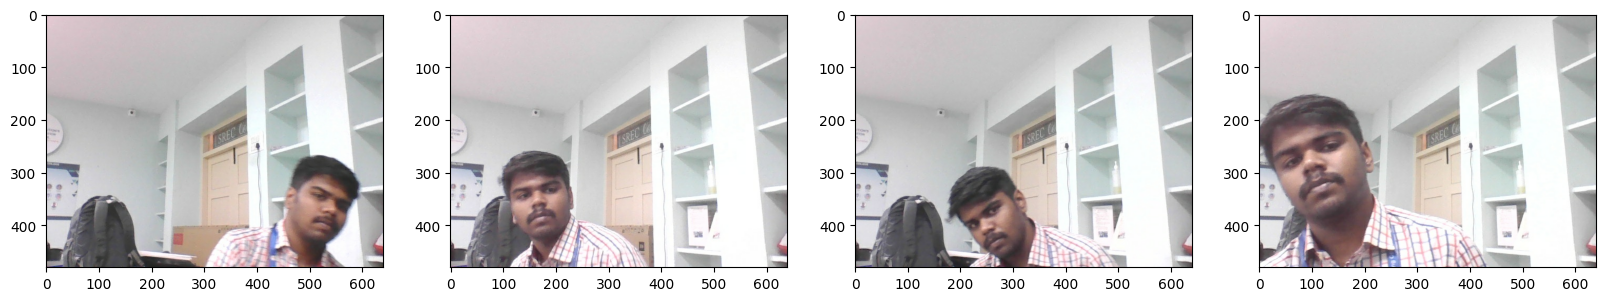

In [117]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [118]:
149*.7 # 63 to train

104.3

In [119]:
149*.15 # 14 and 13 to test and val

22.349999999999998

### 3.2 Move the Matching Labels

In [120]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [6]:
import albumentations as alb

In [7]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [123]:
img = cv2.imread(os.path.join('data','train', 'images','98a47aec-d361-11ed-9a01-ffc1cbde35b3.jpg'))

In [124]:
with open(os.path.join('data', 'train','labels', '98a47aec-d361-11ed-9a01-ffc1cbde35b3.json'), 'r') as f:
    label = json.load(f)

In [125]:
label['shapes'][0]['points']

[[333.0890052356021, 143.1413612565445],
 [491.2041884816754, 400.2094240837696]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [126]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [127]:
coords

[333.0890052356021, 143.1413612565445, 491.2041884816754, 400.2094240837696]

In [128]:
coords = list(np.divide(coords, [640,480,640,480]))

In [129]:
coords

[0.5204515706806283,
 0.2982111692844677,
 0.7675065445026178,
 0.8337696335078533]

### 4.4 Apply Augmentations and View Results

In [130]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [131]:
augmented['bboxes'][0][2:]

(0.2664688772542174, 0.8293542757417102)

In [132]:
augmented['bboxes']

[(0.0, 0.2580919139034323, 0.2664688772542174, 0.8293542757417102)]

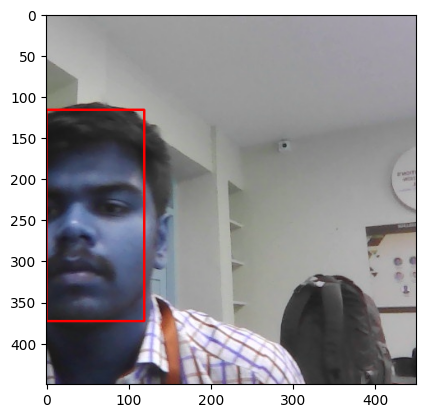

In [133]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [134]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(80):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('data','aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('data','aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [8]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [9]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [10]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [11]:
train_images.as_numpy_iterator().next()

array([[[9.65686291e-02, 4.49509799e-01, 9.65686291e-02],
        [9.62622538e-02, 4.49203432e-01, 9.62622538e-02],
        [9.62622538e-02, 4.49203432e-01, 9.62622538e-02],
        ...,
        [0.00000000e+00, 2.91666657e-01, 3.23529430e-02],
        [0.00000000e+00, 3.01470578e-01, 3.48039232e-02],
        [0.00000000e+00, 3.02512258e-01, 3.41911763e-02]],

       [[9.41176489e-02, 4.47058827e-01, 9.84068662e-02],
        [9.80392173e-02, 4.50980395e-01, 9.80392173e-02],
        [9.75490212e-02, 4.50490206e-01, 9.75490212e-02],
        ...,
        [0.00000000e+00, 3.01960796e-01, 3.52941193e-02],
        [4.90196107e-04, 3.09313715e-01, 3.23529430e-02],
        [0.00000000e+00, 3.01960796e-01, 3.08823530e-02]],

       [[9.80392173e-02, 4.50980395e-01, 9.80392173e-02],
        [9.80392173e-02, 4.50980395e-01, 9.80392173e-02],
        [9.46078449e-02, 4.47549015e-01, 9.46078449e-02],
        ...,
        [0.00000000e+00, 2.98529416e-01, 3.18627469e-02],
        [6.12745134e-05, 3.05

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [12]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [13]:
train_labels = tf.data.Dataset.list_files('data\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels = tf.data.Dataset.list_files('data\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels = tf.data.Dataset.list_files('data\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2795, 0.5317, 0.518 , 0.8076], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [17]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8400, 8400, 1920, 1920, 1600, 1600)

### 7.2 Create Final Datasets (Images/Labels)

In [18]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [19]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [20]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [21]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.03217, 0.     , 0.3765 , 0.3186 ],
        [0.5654 , 0.2048 , 0.8306 , 0.5005 ],
        [0.1902 , 0.6006 , 0.5044 , 0.9727 ],
        [0.05603, 0.1081 , 0.4387 , 0.5293 ],
        [0.7837 , 0.3877 , 1.     , 0.8843 ],
        [0.9004 , 0.0779 , 1.     , 0.556  ],
        [0.3079 , 0.235  , 0.635  , 0.615  ],
        [0.0826 , 0.4912 , 0.3315 , 0.8545 ]], dtype=float16))

### 7.3 View Images and Annotations

In [22]:
data_samples = train.as_numpy_iterator()

In [23]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


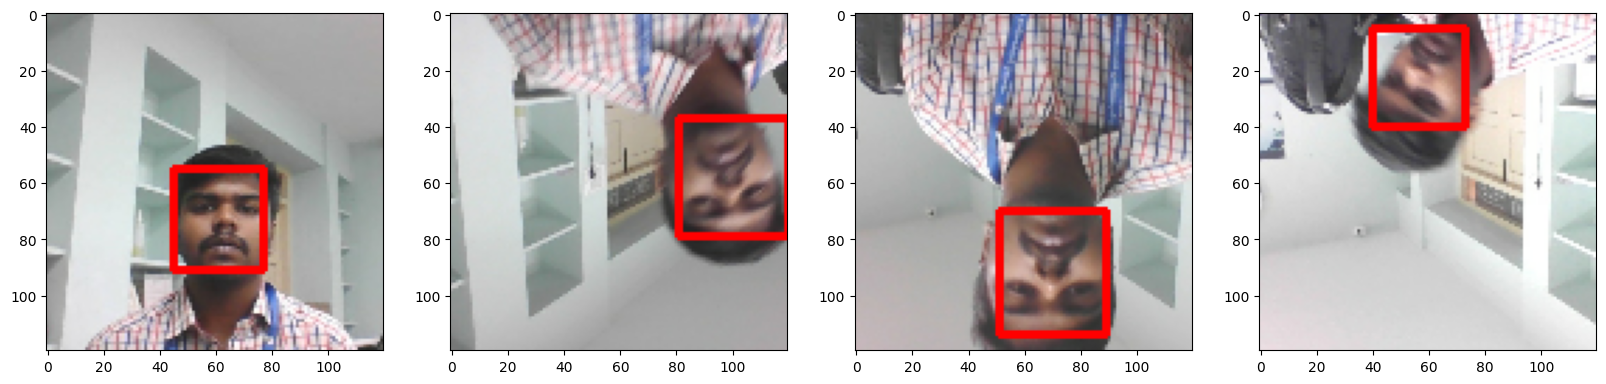

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [5]:
vgg = VGG16(include_top=False)

In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [7]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [8]:
facetracker = build_model()

In [9]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [10]:
X, y = train.as_numpy_iterator().next()

NameError: name 'train' is not defined

In [36]:
X.shape

(8, 120, 120, 3)

In [37]:
classes, coords = facetracker.predict(X)

In [38]:
classes, coords

(array([[0.6015    ],
        [0.5854447 ],
        [0.5920281 ],
        [0.621506  ],
        [0.590647  ],
        [0.57040805],
        [0.42549202],
        [0.5994611 ]], dtype=float32),
 array([[0.4912596 , 0.5131086 , 0.5745573 , 0.46948063],
        [0.4377339 , 0.5180378 , 0.5326096 , 0.6015785 ],
        [0.43275267, 0.4862923 , 0.63088787, 0.50502855],
        [0.4952287 , 0.4862235 , 0.5790905 , 0.4944586 ],
        [0.47833443, 0.5652187 , 0.56568545, 0.5584523 ],
        [0.37540704, 0.46722478, 0.62806517, 0.5236515 ],
        [0.41652304, 0.5560801 , 0.59397244, 0.47851235],
        [0.41371927, 0.466348  , 0.5367397 , 0.56584096]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [39]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [42]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [43]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [44]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8378675>

In [45]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5622119>

In [46]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8378675>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [55]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
        self.accuracy = tf.keras.metrics.BinaryAccuracy()
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        self.accuracy.update_state(y[0], classes)
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss, "accuracy":self.accuracy.result()}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        self.accuracy.update_state(y[0], classes)
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss, "accuracy":self.accuracy.result()}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [56]:
model = FaceTracker(facetracker)

In [57]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [58]:
logdir='logs'
import tensorflow as tf

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [60]:
hist = model.fit(train, epochs=7, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/7
1050/1050 [==============================] - 1238s 1s/step - total_loss: 0.2845 - class_loss: 0.0898 - regress_loss: 0.2396 - accuracy: 0.9707 - val_total_loss: 0.3967 - val_class_loss: 0.0866 - val_regress_loss: 0.3534 - val_accuracy: 0.9556
Epoch 2/7
1050/1050 [==============================] - 1191s 1s/step - total_loss: 0.1164 - class_loss: 0.0336 - regress_loss: 0.0996 - accuracy: 0.9905 - val_total_loss: 1.6773 - val_class_loss: 0.3584 - val_regress_loss: 1.4981 - val_accuracy: 0.9087
Epoch 3/7
1050/1050 [==============================] - 1340s 1s/step - total_loss: 0.0862 - class_loss: 0.0239 - regress_loss: 0.0742 - accuracy: 0.9910 - val_total_loss: 0.9448 - val_class_loss: 0.6356 - val_regress_loss: 0.6270 - val_accuracy: 0.9287
Epoch 4/7
1050/1050 [==============================] - 1251s 1s/step - total_loss: 0.0683 - class_loss: 0.0194 - regress_loss: 0.0586 - accuracy: 0.9928 - val_total_loss: 0.1692 - val_class_loss: 0.1884 - val_regress_loss: 0.0750 - val_accur

### 10.3 Plot Performance

In [61]:
hist.history

{'total_loss': [0.05191326513886452,
  0.06303389370441437,
  0.258251428604126,
  0.025424234569072723,
  0.01707073673605919,
  0.021718014031648636,
  0.012036952190101147],
 'class_loss': [0.014809598214924335,
  0.000715963717084378,
  0.030119573697447777,
  0.0009098839946091175,
  0.0009914893889799714,
  0.0004302924207877368,
  0.00030306089320220053],
 'regress_loss': [0.04450846463441849,
  0.06267590820789337,
  0.24319162964820862,
  0.02496929280459881,
  0.01657499186694622,
  0.021502867341041565,
  0.011885421350598335],
 'accuracy': [0.9700000286102295,
  0.9882143139839172,
  0.9913095235824585,
  0.9934523701667786,
  0.9947618842124939,
  0.9950000047683716,
  0.9965476393699646],
 'val_total_loss': [0.3967396020889282,
  1.677320957183838,
  0.9447880983352661,
  0.16915878653526306,
  0.05393111705780029,
  0.045783206820487976,
  0.013789779506623745],
 'val_class_loss': [0.08663377165794373,
  0.35840141773223877,
  0.6355738043785095,
  0.18839900195598602,
 

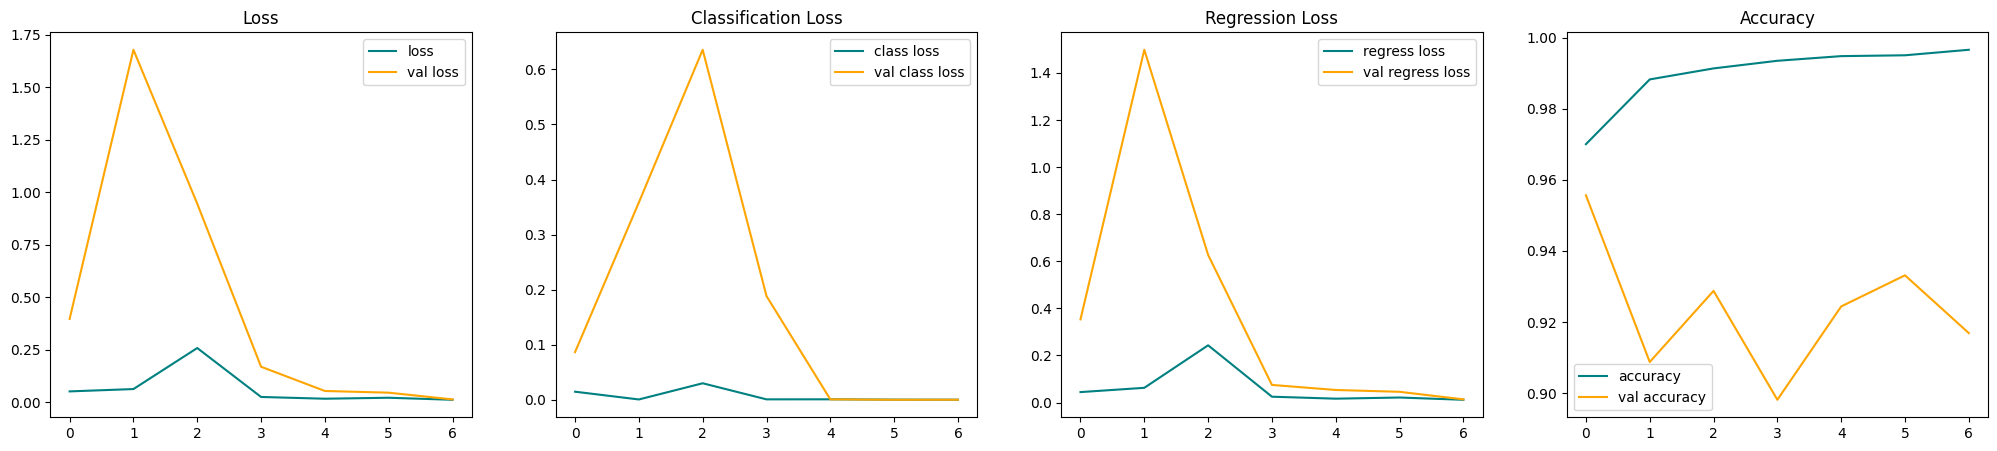

In [62]:
fig, ax = plt.subplots(ncols=4, figsize=(25,5))

# Plot Loss
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

# Plot Classification Loss
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

# Plot Regression Loss
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

# Plot Accuracy
ax[3].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[3].plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
ax[3].title.set_text('Accuracy')
ax[3].legend()

plt.show()


# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [63]:
test_data = test.as_numpy_iterator()

In [64]:
test_sample = test_data.next()

In [65]:
yhat = facetracker.predict(test_sample[0]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


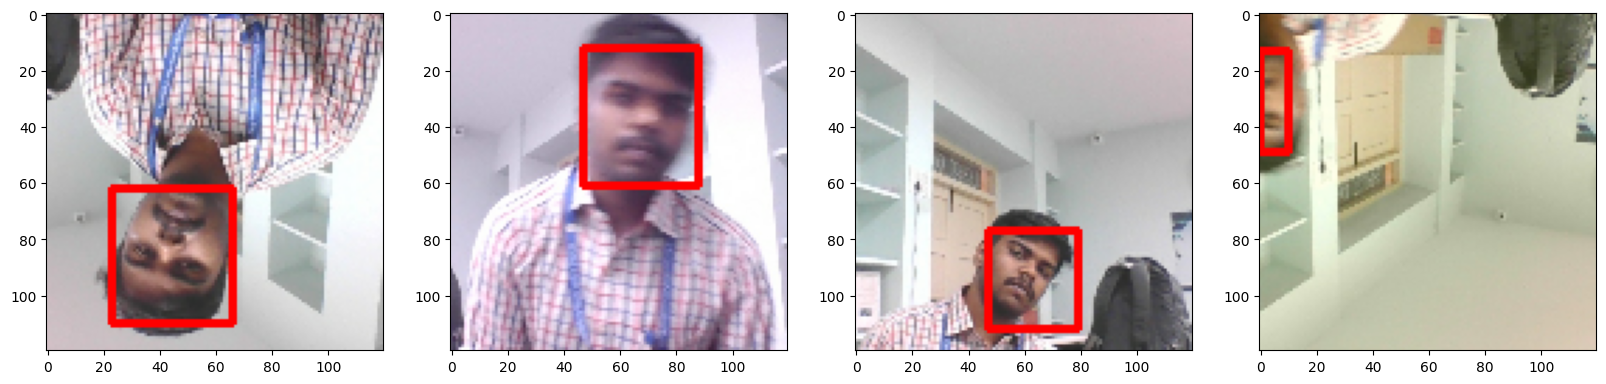

In [66]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
# Load the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Create a BinaryAccuracy object
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

# Evaluate the model on the test dataset

test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the test accuracy
print('Test accuracy:', test_accuracy)


### 11.2 Save the Model

In [11]:
from tensorflow.keras.models import load_model


In [69]:
facetracker.save('facetracker2revised.h5')

In [ ]:

model = load_model('pruned_model.h5', custom_objects=custom_objects)

In [12]:
facetracker = load_model('models/facetracker.h5')

facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [3]:
from keras.models import load_model

# Load the trained model
facetracker = load_model('models/facetracker.h5')

# Get the number of layers in the model
num_layers = len(model.layers)

print("Number of layers in the model:", num_layers)


Number of layers in the model: 8


### 11.3 Real Time Detection

In [4]:
import tensorflow as tf 
import cv2
import numpy as np
import time

cap = cv2.VideoCapture(0)
num_frames = 0
start_time = time.time()
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    img = np.expand_dims(resized/255,0)
    time1 = time.time()
    yhat = facetracker.predict(img)
    time2 = time.time()
    time3 = time2 - time1
    print(time3)
    sample_coords = yhat[1][0]
    print(yhat[1][0])
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)

    num_frames += 1
    fps = num_frames / (time.time() - start_time)
    print(f'Frame rate: {fps:.2f} fps')
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

print(f'Total number of frames: {num_frames}')
print(f'Total elapsed time: {time.time() - start_time:.2f} s')
print(f'Average FPS: {num_frames / (time.time() - start_time):.2f} fps')

2.359685182571411
[0.3614643  0.28320092 0.83559716 0.7529268 ]
Frame rate: 0.35 fps
0.07099723815917969
[0.3805071  0.30455118 0.8158422  0.74012023]
Frame rate: 0.68 fps
0.07253718376159668
[0.37806797 0.30536973 0.8156836  0.7415999 ]
Frame rate: 0.99 fps
0.07753515243530273
[0.37688512 0.3057221  0.81385684 0.741898  ]
Frame rate: 1.28 fps
0.07752013206481934
[0.37688512 0.3057221  0.81385684 0.741898  ]
Frame rate: 1.56 fps
0.059525251388549805
[0.38203567 0.30640322 0.8137238  0.74311835]
Frame rate: 1.82 fps
0.0625455379486084
[0.38028446 0.3077882  0.80947137 0.7397281 ]
Frame rate: 2.08 fps
0.06371498107910156
[0.38074276 0.30579394 0.8092059  0.7376234 ]
Frame rate: 2.30 fps
0.05856633186340332
[0.38074276 0.30579394 0.8092059  0.7376234 ]
Frame rate: 2.54 fps
0.06152987480163574
[0.38171607 0.30929857 0.81161237 0.74057937]
Frame rate: 2.77 fps
0.06252121925354004
[0.38171607 0.30929857 0.81161237 0.74057937]
Frame rate: 2.99 fps
0.06215095520019531
[0.37564087 0.30266654 0.

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# Load the model
model = keras.models.load_model('models/facetracker.h5')



In [7]:
test_datagen = ImageDataGenerator()
test_data = test_datagen.flow_from_directory(
    'C:\\Users\\SM Harikarthik\\Documents\\VSprogramming\\FaceDetection\\detect\\FaceDetection\\images\\',
    target_size=(120, 120),
    batch_size=8,
    class_mode=None
)
test_annotations = test_datagen.flow_from_directory(
    'C:\\Users\\SM Harikarthik\\Documents\\VSprogramming\\FaceDetection\\detect\\FaceDetection\\labels\\',
    target_size=(120, 120),
    batch_size=8,
    class_mode=None
)

# Generate predictions




Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
accuracies = []
for i in range(len(predictions)):
    pred_probs = predictions[i][:, 0]
    pred_boxes = predictions[i][:, 1:]
    true_boxes = get_bounding_boxes(test_annotations[i])
    iou = calculate_iou(pred_boxes, true_boxes)
    accuracies.append(iou)
accuracy = sum(accuracies) / len(accuracies)
print('Test accuracy:', accuracy)

In [1]:
import cv2
imgg = cv2.imread('bag.jpg')
imgg = cv2.imshow('Image', imgg)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

In [1]:
import tensorrt 

ModuleNotFoundError: No module named 'tensorrt'

In [8]:
import tensorflow as tf 
import cv2
import numpy as np
import time

cap = cv2.VideoCapture(0)
num_frames = 0
start_time = time.time()
total_inference_time = 0

while cap.isOpened() and num_frames <=100:
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    img = np.expand_dims(resized/255,0)
    time1 = time.time()
    yhat = facetracker.predict(img)
    time2 = time.time()
    time3 = time2 - time1
    total_inference_time += time3  # Add current inference time to total inference time
    print(f"Inference time: {time3:.3f} s")
    print(yhat[1][0])
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)

    num_frames += 1
    fps = num_frames / (time.time() - start_time)
    print(f'Frame rate: {fps:.2f} fps')
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Calculate and print the average inference time
avg_inference_time = total_inference_time / num_frames
print(f'Total number of frames: {num_frames}')
print(f'Total elapsed time: {time.time() - start_time:.2f} s')
print(f'Average FPS: {fps:.2f} fps')
print(f'Average inference time: {avg_inference_time:.2f} s')


Inference time: 0.067 s
[0.47689068 0.27273345 0.8269237  0.6354497 ]
Frame rate: 1.35 fps
Inference time: 0.081 s
[0.45393145 0.27053896 0.8099102  0.6343081 ]
Frame rate: 2.38 fps
Inference time: 0.067 s
[0.4541684 0.2740342 0.7980939 0.6329004]
Frame rate: 3.26 fps
Inference time: 0.076 s
[0.4374768  0.27372482 0.75231063 0.63391954]
Frame rate: 3.83 fps
Inference time: 0.067 s
[0.4374768  0.27372482 0.75231063 0.63391954]
Frame rate: 4.43 fps
Inference time: 0.062 s
[0.37788457 0.27479926 0.68168485 0.6457297 ]
Frame rate: 4.93 fps
Inference time: 0.068 s
[0.33092767 0.2828293  0.6425046  0.6702936 ]
Frame rate: 5.37 fps
Inference time: 0.069 s
[0.33092767 0.2828293  0.6425046  0.6702936 ]
Frame rate: 5.72 fps
Inference time: 0.064 s
[0.23011714 0.28847855 0.5704939  0.68443656]
Frame rate: 6.04 fps
Inference time: 0.070 s
[0.12085554 0.29287165 0.49591672 0.7340418 ]
Frame rate: 6.34 fps
Inference time: 0.063 s
[0.12085554 0.29287165 0.49591672 0.7340418 ]
Frame rate: 6.62 fps
Inf